## Imports

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import UnivariateSpline
import h5py
from scipy.integrate import quadrature
import pickle

import warnings

warnings.filterwarnings('ignore')

In [22]:
h5pydir = 'h5py_dat/'

In [23]:
plt.style.use("/Users/nolansmyth/Dropbox/kinetic_recoupling/figures/style.mplstyle")

## Parameters and Constants

In [24]:
spline_pars = {'k': 3, 's': 0.0}

z_pk = 0.0; #redshift at which Pk is determined
pk_max = 1.e2; #maximum k for Pk
kk = np.logspace(-4,np.log10(pk_max),500)
f_idm_dr = 1.0
omega0_cdm = 0.12038;
xi = 0.3
BM_KS = [str(round(n,1)) for n in np.geomspace(.1, 10, 10)]
ktoev = 8.6173e-5

In [25]:
BM_KS

['0.1', '0.2', '0.3', '0.5', '0.8', '1.3', '2.2', '3.6', '6.0', '10.0']

## Functions

In [28]:
def scientific_format(x):
    s = '%.1e' % x
    mantissa, exponent = s.split('e')
    return r'${} \times 10^{{{}}}$'.format(mantissa, int(exponent))    

## Recoupling rate calculation

In [29]:
def my_dmu_idm_dr(z, A_rec, a_idm_dr = 1, Omega0_idm_dr = 0.12038, T_rec = 6.0e5, xi_idr = 0.3, sigma_fac = 0.001):

    sigma = sigma_fac*T_rec
    base_rate = a_idm_dr * ((1+z)/(1e7))**4 * Omega0_idm_dr 
    T_idr = (xi_idr * 2.73) * (1+z)
    delta = T_idr - T_rec
    delta = delta/sigma
    gauss = np.exp(-pow(delta,2)/2)/np.sqrt(2*np.pi)

    return base_rate * (1 + A_rec / sigma * gauss)

In [30]:
for num in np.array([6e6, 6e5*np.sqrt(10), 6e5, 6e4*np.sqrt(10), 6e4])*ktoev:
    print(scientific_format(num))


$5.2 \times 10^{2}$
$1.6 \times 10^{2}$
$5.2 \times 10^{1}$
$1.6 \times 10^{1}$
$5.2 \times 10^{0}$


In [31]:
[7.3e6, 2.3e6, 7.3e5, 2.3e5, 7.3e4]
[5.2e2, 1.6e2, 5.2e1, 1.6e1, 5.2e0]

[520.0, 160.0, 52.0, 16.0, 5.2]

In [32]:
T_recs = [6e6, 6e5*np.sqrt(10), 6e5, 6e4*np.sqrt(10), 6e4]


In [33]:
np.logspace(np.log10(6e4), np.log10(6e7), 5)

array([   60000.        ,   337404.79511421,  1897366.59610103,
       10669676.46023354, 60000000.00000003])

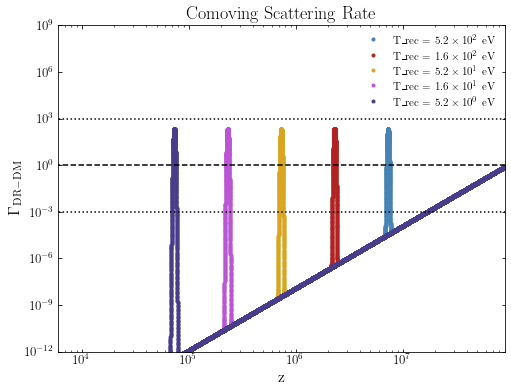

In [34]:
z_data = np.geomspace(1e-3,1e8,int(1e5))

A_recs = [1e12, 10**(13.5), 1e15, 10**(16.5), 1e18]
T_recs = [6e6, 6e5*np.sqrt(10), 6e5, 6e4*np.sqrt(10), 6e4]


for i, A_rec in enumerate(A_recs):
    plt.plot(z_data, my_dmu_idm_dr(z_data, A_recs[i], a_idm_dr = 1e-3, T_rec=T_recs[i], sigma_fac=0.01), '.', label='T_rec = {} eV'.format(scientific_format(ktoev*T_recs[i])))

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(6e3,9e7)
plt.ylim(1e-12,1e9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

## Matter Power Spectrum

In [35]:
for A_rec in [A_recs[0]]:
    data_file=h5pydir+'delta_data_' +'%.2e'%A_rec+'.hdf5'
    with h5py.File(data_file, 'r') as f:
        print(f['scalar'].keys())

<KeysViewHDF5 ['k=0.1', 'k=0.2', 'k=0.3', 'k=0.5', 'k=0.8', 'k=1.3', 'k=10.0', 'k=2.2', 'k=3.6', 'k=6.0']>


In [47]:
#Get data for cases with recoupling
BM_KS = [str(round(n,1)) for n in np.geomspace(.1, 10, 10)]
k = BM_KS[0]

delta_chi_arr = []
delta_chi_dot_arr = []
phi_dot_arr = []
Pk_arr = []
kappa_dot_taus_arr = []
kappa_dot_zs_arr = []
z_arr = []
tau_arr = []
thermo_tau_arr = []
theta_dr_arr = []
rho_idr_arr = []
rho_idm_arr = []
theta_chi_dot_arr = []
theta_chi_arr = []
delta_idr_arr = []

for A_rec in A_recs:
    data_file=h5pydir+'delta_data_' +'%.2e'%A_rec+'.hdf5'
    with h5py.File(data_file, 'r') as f:
        tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
        delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
        phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
        kappa_dot_data = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
        z_data = np.flip(np.array(f['thermodynamics']['z']))
        thermo_tau_data = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))
        cx2_data = np.flip(np.array(f['thermodynamics']['c_idm_dr^2']))

        theta_data = np.array(f['scalar']['k='+str(k)]['theta_idm_dr'])
        theta_dr_data = np.array(f['scalar']['k='+str(k)]['theta_idr'])

        delta_idr_data = np.array(f['scalar']['k='+str(k)]['delta_idr'])

        psi_data = np.array(f['scalar']['k='+str(k)]['psi'])

        rho_idr_data = np.array(f['background']['(.)rho_idr'])
        rho_idm_data = np.array(f['background']['(.)rho_idm_dr'])
        bkg_tau_data = np.array(f['background']['conf. time [Mpc]'])

        rho_idr = UnivariateSpline(bkg_tau_data, rho_idr_data, **spline_pars)
        rho_idm = UnivariateSpline(bkg_tau_data, rho_idm_data, **spline_pars)

        delta_chi = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
        delta_chi_dot = delta_chi.derivative()
        delta_chi_ddot = delta_chi_dot.derivative()

        delta_idr = UnivariateSpline(tau_data, delta_idr_data, **spline_pars)

        phi = UnivariateSpline(tau_data, phi_data, **spline_pars)
        phi_dot = phi.derivative()
        phi_ddot = phi_dot.derivative()

        theta_chi = UnivariateSpline(tau_data, theta_data, **spline_pars)
        theta_chi_dot = theta_chi.derivative()
        theta_dr = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

        psi = UnivariateSpline(tau_data, psi_data, **spline_pars)
        cx2_chi = UnivariateSpline(thermo_tau_data, cx2_data, **spline_pars)

        kappa_dot_taus = UnivariateSpline(thermo_tau_data, kappa_dot_data, **spline_pars)
        kappa_dot_zs = UnivariateSpline(np.flip(z_data), np.flip(kappa_dot_data), **spline_pars)
        thermo_taus = UnivariateSpline(np.flip(z_data), np.flip(thermo_tau_data), **spline_pars)

        a_data = 1/(1+z_data)
        a = UnivariateSpline(thermo_tau_data, a_data, **spline_pars)
        aprime = a.derivative()

        Pks = np.array(f['power_spectrum']['Pk'])
        kks = np.array(f['power_spectrum']['kk'])

        delta_idr_arr.append(delta_idr)
        delta_chi_arr.append(delta_chi)
        delta_chi_dot_arr.append(delta_chi_dot)
        Pk_arr.append(Pks)
        kappa_dot_taus_arr.append(kappa_dot_taus)
        kappa_dot_zs_arr.append(kappa_dot_zs)
        z_arr.append(z_data)
        tau_arr.append(tau_data)
        phi_dot_arr.append(phi_dot)
        thermo_tau_arr.append(thermo_taus)
        theta_dr_arr.append(theta_dr)
        rho_idr_arr.append(rho_idr)
        rho_idm_arr.append(rho_idm)
        theta_chi_arr.append(theta_chi)
        theta_chi_dot_arr.append(theta_chi_dot)

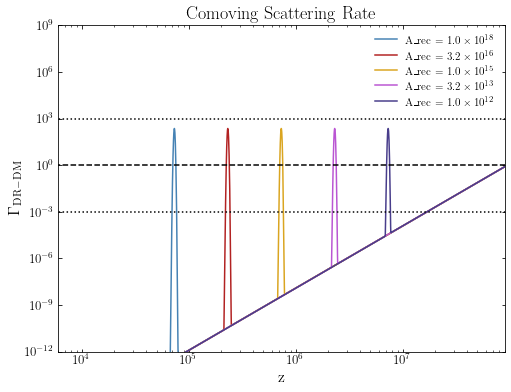

In [76]:
for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(z_arr[i], kappa_dot_zs_arr[i](z_arr[i]), label='A_rec = ' + scientific_format(A_rec))

plt.plot([1e-3,1e10], [1,1], 'k--')
plt.plot([1e-3,1e10], [1e-3,1e-3], 'k:')
plt.plot([1e-3,1e10], [1e3,1e3], 'k:')

plt.xlim(6e3,9e7)
plt.ylim(1e-12,1e9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('z', fontsize=16)
plt.ylabel('$\Gamma_{\mathrm{DR-DM}}$', fontsize=16)
plt.title('Comoving Scattering Rate')
plt.legend()
plt.show()

In [37]:
BM_KS = [str(round(n,1)) for n in np.geomspace(1, 10, 5)]
k = BM_KS[0]

#Get data for case with no recoupling
data_file=h5pydir+'class_testing_no_rec.hdf5'
with h5py.File(data_file, 'r') as f:
    tau_data = np.array(f['scalar']['k='+str(k)]['tau [Mpc]'])
    delta_chi_data = np.array(f['scalar']['k='+str(k)]['delta_idm_dr'])
    phi_data = np.array(f['scalar']['k='+str(k)]['phi'])
    theta_dr_data = np.array(f['scalar']['k='+str(k)]['theta_idr'])
    theta_data = np.array(f['scalar']['k='+str(k)]['theta_idm_dr'])
    
    
    delta_chi_no_rec = UnivariateSpline(tau_data, delta_chi_data, **spline_pars)
    delta_chi_dot_no_rec = delta_chi_no_rec.derivative()
    phi_no_rec = UnivariateSpline(tau_data, phi_data, **spline_pars)
    phi_dot_no_rec = phi_no_rec.derivative()
    theta_dr_no_rec = UnivariateSpline(tau_data, theta_dr_data, **spline_pars)

    theta_chi_no_rec = UnivariateSpline(tau_data, theta_data, **spline_pars)
    theta_chi_dot_no_rec = theta_chi_no_rec.derivative()

    Pks_no_rec = np.array(f['power_spectrum']['Pk'])
    kks_no_rec = np.array(f['power_spectrum']['kk'])

    kappa_dot_data_no_rec = np.flip(np.array(f['thermodynamics']['dmu_idm_dr']))
    z_data_no_rec = np.flip(np.array(f['thermodynamics']['z']))
    thermo_tau_data_no_rec = np.flip(np.array(f['thermodynamics']['conf. time [Mpc]']))

    rho_idr_no_rec = np.array(f['background']['(.)rho_idr'])
    rho_idm_no_rec = np.array(f['background']['(.)rho_idm_dr'])
    bkg_zs_no_rec = np.array(f['background']['z'])
    clTT_no_rec = np.array(f['cmb']['tt'])
    ll_no_rec = np.array(f['cmb']['ell'])

    thermo_taus_no_rec = UnivariateSpline(np.flip(z_data_no_rec), np.flip(thermo_tau_data_no_rec), **spline_pars)

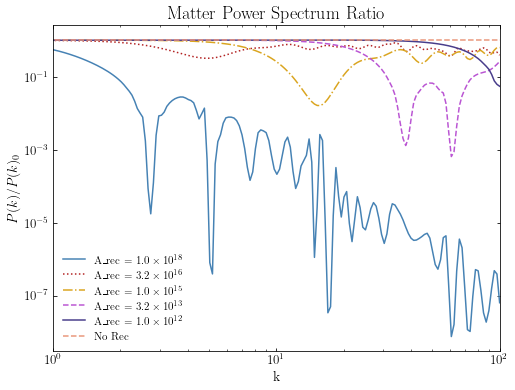

In [38]:
lines = ["-","--","-.",":"]
for i, A_rec in reversed(list(enumerate(A_recs))):
    plt.plot(kk, Pk_arr[i]/Pks_no_rec,  ls = lines[i%len(lines)], label='A_rec = ' + scientific_format(A_rec))

plt.plot(kk,Pks_no_rec/Pks_no_rec, '--', label='No Rec')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('k')
plt.ylabel('$P(k)/P(k)_0$')
plt.title('Matter Power Spectrum Ratio')
plt.xlim(1,1e2)
plt.legend()
plt.show()

In [44]:
plt.plot(tau_arr[0], delta_idr_arr[0](tau_arr[0]), label='A_rec = ' + scientific_format(A_recs[0]))
plt.xscale('log')
plt.xlabel('tau')

TypeError: 'numpy.ndarray' object is not callable